##Installations

###Download prepared dataset

split_v3:
https://drive.google.com/file/d/1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu/view?usp=drive_link

In [3]:
!gdown 1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu

Downloading...
From: https://drive.google.com/uc?id=1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu
To: /content/splits_v3.zip
100% 476M/476M [00:02<00:00, 234MB/s]


In [4]:
!unzip splits_v3.zip

Archive:  splits_v3.zip
replace splits_v3/validation/glass/glass_674.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

###Read files

Since the dataset has been prepared (chosen, resized, splitted), just get each available set (train, validation, test)

In [7]:
import os
import numpy as np
import cv2

The labels for each set are the same, so just reuse it:

In [8]:
labels = sorted(os.listdir('/content/splits_v3/train'))

In [9]:
labels

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

####Get train set

In [10]:
train = dict()

for label in labels:
    img_paths = list(os.listdir('./splits_v3/train/' + label))
    img_paths = map(lambda p: f'./splits_v3/train/{label}/{p}', img_paths)
    train[label] = []
    for path in img_paths:
        img = cv2.imread(path)
        train[label].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [11]:
X_train = []
y_train = []

for encoded_label, label in enumerate(labels):
    y_train += [encoded_label] * len(train[label])
    X_train += train[label]

In [12]:
y_train = np.array(y_train)
X_train = np.array(X_train)

Check train set:

In [13]:
y_train.shape

(3260,)

In [14]:
X_train.shape

(3260, 300, 400, 3)

####Get validation set

In [15]:
validation = dict()

for label in labels:
    img_paths = list(os.listdir('./splits_v3/validation/' + label))
    img_paths = map(lambda p: f'./splits_v3/validation/{label}/{p}', img_paths)
    validation[label] = []
    for path in img_paths:
        img = cv2.imread(path)
        validation[label].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [16]:
X_dev = []
y_dev = []

for encoded_label, label in enumerate(labels):
    y_dev += [encoded_label] * len(validation[label])
    X_dev += validation[label]

In [17]:
y_dev = np.array(y_dev)
X_dev = np.array(X_dev)

Check validation set:

In [18]:
y_dev.shape

(699,)

In [19]:
X_dev.shape

(699, 300, 400, 3)

####Get test set

In [20]:
test = dict()

for label in labels:
    img_paths = list(os.listdir('./splits_v3/test/' + label))
    img_paths = map(lambda p: f'./splits_v3/test/{label}/{p}', img_paths)
    test[label] = []
    for path in img_paths:
        img = cv2.imread(path)
        test[label].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [21]:
X_test = []
y_test = []

for encoded_label, label in enumerate(labels):
    y_test += [encoded_label] * len(test[label])
    X_test += test[label]

In [22]:
y_test = np.array(y_test)
X_test = np.array(X_test)

Check test set:

In [23]:
y_test.shape

(699,)

In [24]:
X_test.shape

(699, 300, 400, 3)

##Feature Engineering

In [25]:
import tensorflow as tf

In [26]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#### Transfer pretrained model

##### Construct model

In [27]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = (300, 400, 3)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
base_model.trainable = False
base_model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [28]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 13, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


##### Save FE model

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [34]:
!mkdir pretrained_models

In [35]:
%cd pretrained_models

/content/drive/MyDrive/pretrained_models


In [36]:
tf.keras.models.save_model(model, 'ResNet50_SVMFE', save_format='h5')

#### Feature Extraction

In [37]:
del train, test, validation

In [38]:
X_train_fe = model.predict(X_train)
X_test_fe = model.predict(X_test)
X_dev_fe = model.predict(X_dev)

22/22 [==============================] - 5s 226ms/step


#### Explore results

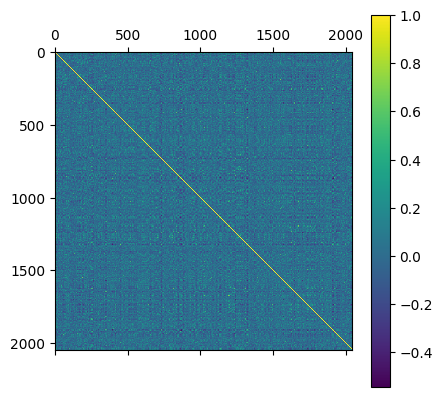

In [41]:
plt.matshow(pd.DataFrame(X_train_fe).corr())
plt.colorbar()
plt.show()

min: -0.350836927880998, max: 0.3045924189326564


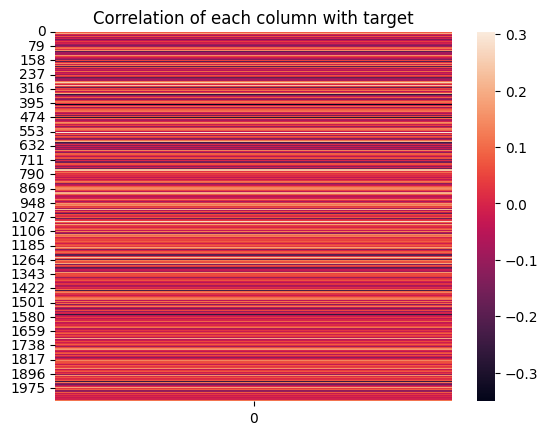

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(X_train_fe)
df['target'] = y_train

corr_with_target = df.drop(columns='target').corrwith(df['target'])
# fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 5))

sns.heatmap(pd.DataFrame(corr_with_target))
# ax1.set_title('Correlation with target value')
plt.title("Correlation of each column with target");
print(f"min: {corr_with_target.min()}, max: {corr_with_target.max()}")

In [42]:
corr_with_target.min(), corr_with_target.max()

(-0.350836927880998, 0.3045924189326564)

(array([  6.,  29.,  74., 159., 385., 577., 505., 236.,  67.,  10.]),
 array([-0.35083693, -0.28529399, -0.21975106, -0.15420812, -0.08866519,
        -0.02312225,  0.04242068,  0.10796361,  0.17350655,  0.23904948,
         0.30459242]),
 <BarContainer object of 10 artists>)

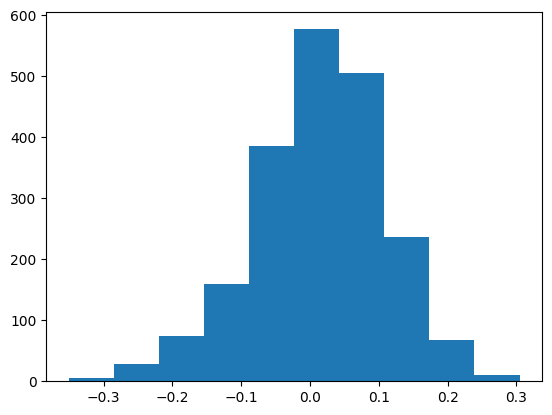

In [43]:
plt.hist(corr_with_target)

### Shuffle dataset

In [45]:
from sklearn.utils import shuffle
X_train_fe, y_train = shuffle(X_train_fe, y_train, random_state=7)
X_dev_fe, y_dev = shuffle(X_dev_fe, y_dev, random_state=7)
X_test_fe, y_test = shuffle(X_test_fe, y_test, random_state=7)

### Optional: Drop low correlated columns

Goal: to take less time training

Không ảnh hưởng performance:

- Trước khi drop:
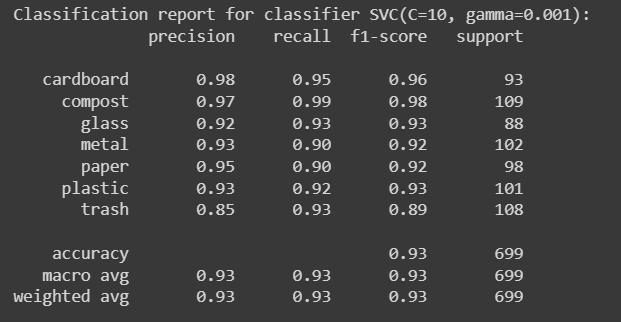
- Sau khi drop khoảng (-0.02, 0.02):
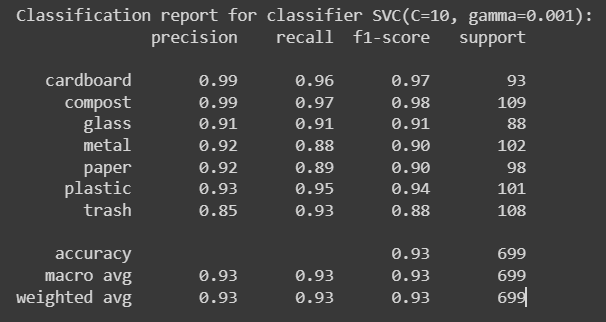

In [ ]:
# indices = [i for i, c in enumerate(corr_with_target) if -0.02 < c < 0.02 ]

In [ ]:
# np.delete(X_train_fe, indices, axis=1).shape

(3260, 1366)

In [ ]:
# X_train_fe = np.delete(X_train_fe, indices, axis=1)
# X_dev_fe = np.delete(X_dev_fe, indices, axis=1)
# X_test_fe = np.delete(X_test_fe, indices, axis=1)

##Hyperparameter Tuning

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [47]:
X_traindev = np.concatenate([X_train_fe, X_dev_fe], axis = 0)

In [48]:
y_traindev = np.concatenate([y_train, y_dev], axis = 0)

In [49]:
param_grid = {'C': np.logspace(0, 2, 3),
              'gamma': np.logspace(-5, -1, 5),
              'kernel': ['rbf']}

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1275, random_state=42)

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=cv)

grid.fit(X_traindev, y_traindev)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END ....C=1.0, gamma=1e-05, kernel=rbf;, score=0.406 total time=  19.7s
[CV 2/3] END ....C=1.0, gamma=1e-05, kernel=rbf;, score=0.424 total time=  18.8s
[CV 3/3] END ....C=1.0, gamma=1e-05, kernel=rbf;, score=0.416 total time=  18.3s
[CV 1/3] END ...C=1.0, gamma=0.0001, kernel=rbf;, score=0.772 total time=  12.2s
[CV 2/3] END ...C=1.0, gamma=0.0001, kernel=rbf;, score=0.764 total time=  11.8s
[CV 3/3] END ...C=1.0, gamma=0.0001, kernel=rbf;, score=0.762 total time=  11.3s
[CV 1/3] END ....C=1.0, gamma=0.001, kernel=rbf;, score=0.861 total time=   8.0s
[CV 2/3] END ....C=1.0, gamma=0.001, kernel=rbf;, score=0.857 total time=   8.3s
[CV 3/3] END ....C=1.0, gamma=0.001, kernel=rbf;, score=0.863 total time=   7.5s
[CV 1/3] END .....C=1.0, gamma=0.01, kernel=rbf;, score=0.850 total time=  19.8s
[CV 2/3] END .....C=1.0, gamma=0.01, kernel=rbf;, score=0.879 total time=  19.1s
[CV 3/3] END .....C=1.0, gamma=0.01, kernel=rbf;

The best parameters are {'C': 10.0, 'gamma': 0.0001, 'kernel': 'rbf'} with a score of 0.86 => test : 0.84


The best parameters are {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'} with a score of 0.85 => test: 0.86




Edit: The best parameters are {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'} with a score of 0.93 => test: 0.86

##Create a model

In [51]:
clf = SVC(C=100, gamma=0.001, kernel='rbf')

In [52]:
clf.fit(X_train_fe, y_train)

SVC(C=100, gamma=0.001)

In [53]:
import pickle
pickle.dump(clf, open('SVM_ResNet50.pkl', 'wb'))

##Prediction

##Evaluation metrics

### Train/dev eval

In [54]:
from sklearn import metrics
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_train, clf.predict(X_train_fe))}\n"
)

Classification report for classifier SVC(C=100, gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       431
           1       1.00      1.00      1.00       507
           2       1.00      1.00      1.00       413
           3       1.00      1.00      1.00       477
           4       1.00      1.00      1.00       457
           5       1.00      1.00      1.00       473
           6       1.00      1.00      1.00       502

    accuracy                           1.00      3260
   macro avg       1.00      1.00      1.00      3260
weighted avg       1.00      1.00      1.00      3260




In [55]:
from sklearn import metrics
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_dev, clf.predict(X_dev_fe))}\n"
)

Classification report for classifier SVC(C=100, gamma=0.001):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        92
           1       0.96      0.98      0.97       109
           2       0.89      0.87      0.88        89
           3       0.85      0.91      0.88       102
           4       0.94      0.91      0.92        98
           5       0.87      0.85      0.86       102
           6       0.90      0.88      0.89       107

    accuracy                           0.91       699
   macro avg       0.91      0.90      0.91       699
weighted avg       0.91      0.91      0.91       699




### Test eval

In [56]:
y_pred = clf.predict(X_test_fe)

In [57]:
from sklearn import metrics
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, y_pred, target_names=labels)}\n"
)

Classification report for classifier SVC(C=100, gamma=0.001):
              precision    recall  f1-score   support

   cardboard       0.98      0.95      0.96        93
     compost       0.96      0.99      0.97       109
       glass       0.92      0.93      0.93        88
       metal       0.94      0.90      0.92       102
       paper       0.95      0.90      0.92        98
     plastic       0.93      0.93      0.93       101
       trash       0.85      0.91      0.88       108

    accuracy                           0.93       699
   macro avg       0.93      0.93      0.93       699
weighted avg       0.93      0.93      0.93       699




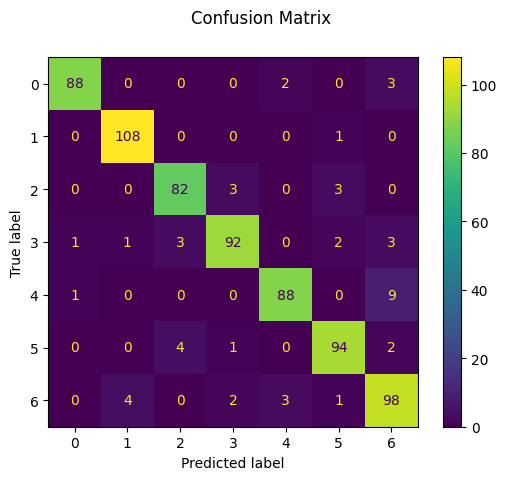

In [58]:
import matplotlib.pyplot as plt
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show();

In [59]:
labels

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']